In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Kết nối đến MongoDB
def connect_to_database():
    client = MongoClient('mongodb://localhost:27017/')
    return client['employee_db']

In [4]:
# 1. Biểu đồ phân bố nhân sự theo phòng ban
def plot_employee_distribution(db):
    pipeline = [
        {"$group": {"_id": "$department_id", "count": {"$sum": 1}}},
        {"$lookup": {"from": "departments", "localField": "_id", "foreignField": "_id", "as": "department"}},
        {"$unwind": "$department"},
        {"$project": {"department_name": "$department.name", "count": 1}}
    ]
    data = list(db.employees.aggregate(pipeline))
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(10, 6))
    plt.bar(df['department_name'], df['count'])
    plt.title('Phân bố nhân sự theo phòng ban')
    plt.xlabel('Phòng ban')
    plt.ylabel('Số lượng nhân viên')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:
# 2. Biểu đồ độ tuổi nhân sự
def plot_age_distribution(db):
    current_year = datetime.now().year
    pipeline = [
        {"$project": {"age": {"$subtract": [current_year, {"$year": "$birth_date"}]}}},
        {"$group": {
            "_id": {
                "$switch": {
                    "branches": [
                        {"case": {"$lt": ["$age", 30]}, "then": "<30"},
                        {"case": {"$and": [{"$gte": ["$age", 30]}, {"$lt": ["$age", 41]}]}, "then": "30-40"},
                        {"case": {"$and": [{"$gte": ["$age", 41]}, {"$lt": ["$age", 51]}]}, "then": "41-50"}
                    ],
                    "default": ">50"
                }
            },
            "count": {"$sum": 1}
        }}
    ]
    data = list(db.employees.aggregate(pipeline))
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(8, 8))
    plt.pie(df['count'], labels=df['_id'], autopct='%1.1f%%')
    plt.title('Phân bố độ tuổi nhân sự')
    plt.axis('equal')
    plt.show()


In [6]:
# 3. Biểu đồ đánh giá hiệu suất nhân viên
def plot_performance_evaluation(db):
    pipeline = [
        {"$group": {"_id": "$employee_id", "avg_score": {"$avg": "$score"}}},
        {"$lookup": {"from": "employees", "localField": "_id", "foreignField": "_id", "as": "employee"}},
        {"$unwind": "$employee"},
        {"$project": {"name": {"$concat": ["$employee.first_name", " ", "$employee.last_name"]}, "avg_score": 1}},
        {"$sort": {"avg_score": -1}},
        {"$limit": 10}
    ]
    data = list(db.performance_evaluations.aggregate(pipeline))
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(12, 6))
    plt.bar(df['name'], df['avg_score'])
    plt.title('Top 10 nhân viên có hiệu suất cao nhất')
    plt.xlabel('Nhân viên')
    plt.ylabel('Điểm đánh giá trung bình')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [7]:
# 4. Biểu đồ đào tạo và phát triển
def plot_training_effectiveness(db):
    pipeline = [
        {"$group": {"_id": "$program_id", "avg_performance": {"$avg": "$performance_score"}}},
        {"$lookup": {"from": "training_programs", "localField": "_id", "foreignField": "_id", "as": "program"}},
        {"$unwind": "$program"},
        {"$project": {"program_name": "$program.name", "avg_performance": 1}}
    ]
    data = list(db.employee_training.aggregate(pipeline))
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(10, 6))
    plt.bar(df['program_name'], df['avg_performance'])
    plt.title('Hiệu quả của các chương trình đào tạo')
    plt.xlabel('Chương trình đào tạo')
    plt.ylabel('Điểm hiệu suất trung bình')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [8]:
# 5. Biểu đồ thâm niên nhân viên
def plot_employee_tenure(db):
    current_date = datetime.now()
    pipeline = [
        {"$project": {
            "tenure": {
                "$switch": {
                    "branches": [
                        {"case": {"$lt": [{"$subtract": [current_date, "$hire_date"]}, {"$multiply": [365, 24, 60, 60, 1000]}]}, "then": "<1 năm"},
                        {"case": {"$and": [
                            {"$gte": [{"$subtract": [current_date, "$hire_date"]}, {"$multiply": [1, 365, 24, 60, 60, 1000]}]},
                            {"$lt": [{"$subtract": [current_date, "$hire_date"]}, {"$multiply": [4, 365, 24, 60, 60, 1000]}]}
                        ]}, "then": "1-3 năm"},
                        {"case": {"$and": [
                            {"$gte": [{"$subtract": [current_date, "$hire_date"]}, {"$multiply": [4, 365, 24, 60, 60, 1000]}]},
                            {"$lt": [{"$subtract": [current_date, "$hire_date"]}, {"$multiply": [8, 365, 24, 60, 60, 1000]}]}
                        ]}, "then": "4-7 năm"},
                        {"case": {"$and": [
                            {"$gte": [{"$subtract": [current_date, "$hire_date"]}, {"$multiply": [8, 365, 24, 60, 60, 1000]}]},
                            {"$lt": [{"$subtract": [current_date, "$hire_date"]}, {"$multiply": [11, 365, 24, 60, 60, 1000]}]}
                        ]}, "then": "8-10 năm"}
                    ],
                    "default": ">10 năm"
                }
            }
        }},
        {"$group": {"_id": "$tenure", "count": {"$sum": 1}}}
    ]
    data = list(db.employees.aggregate(pipeline))
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(10, 6))
    plt.bar(df['_id'], df['count'])
    plt.title('Thâm niên nhân viên')
    plt.xlabel('Nhóm thâm niên')
    plt.ylabel('Số lượng nhân viên')
    plt.tight_layout()
    plt.show()


Chọn biểu đồ bạn muốn xem:
1. Phân bố nhân sự theo phòng ban
2. Độ tuổi nhân sự
3. Đánh giá hiệu suất nhân viên
4. Hiệu quả đào tạo và phát triển
5. Thâm niên nhân viên
0. Thoát


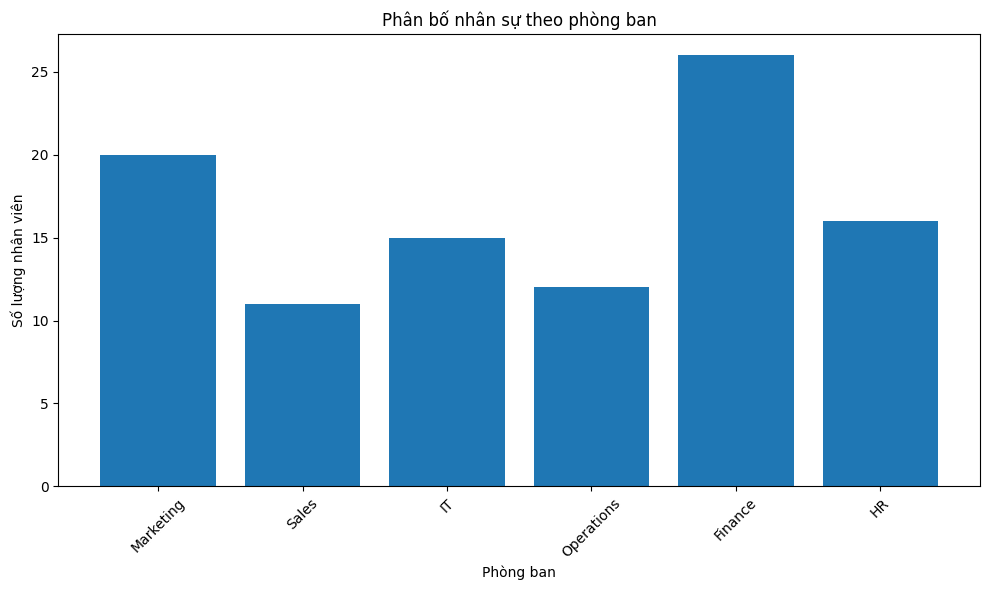


Chọn biểu đồ bạn muốn xem:
1. Phân bố nhân sự theo phòng ban
2. Độ tuổi nhân sự
3. Đánh giá hiệu suất nhân viên
4. Hiệu quả đào tạo và phát triển
5. Thâm niên nhân viên
0. Thoát


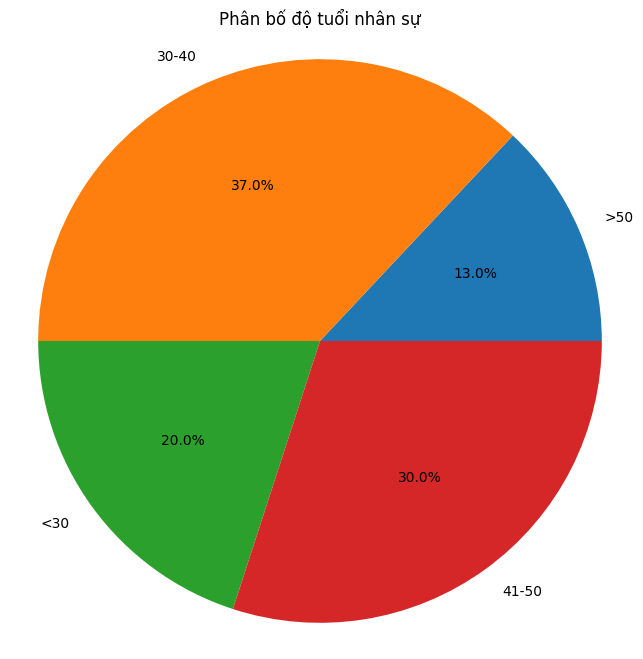


Chọn biểu đồ bạn muốn xem:
1. Phân bố nhân sự theo phòng ban
2. Độ tuổi nhân sự
3. Đánh giá hiệu suất nhân viên
4. Hiệu quả đào tạo và phát triển
5. Thâm niên nhân viên
0. Thoát


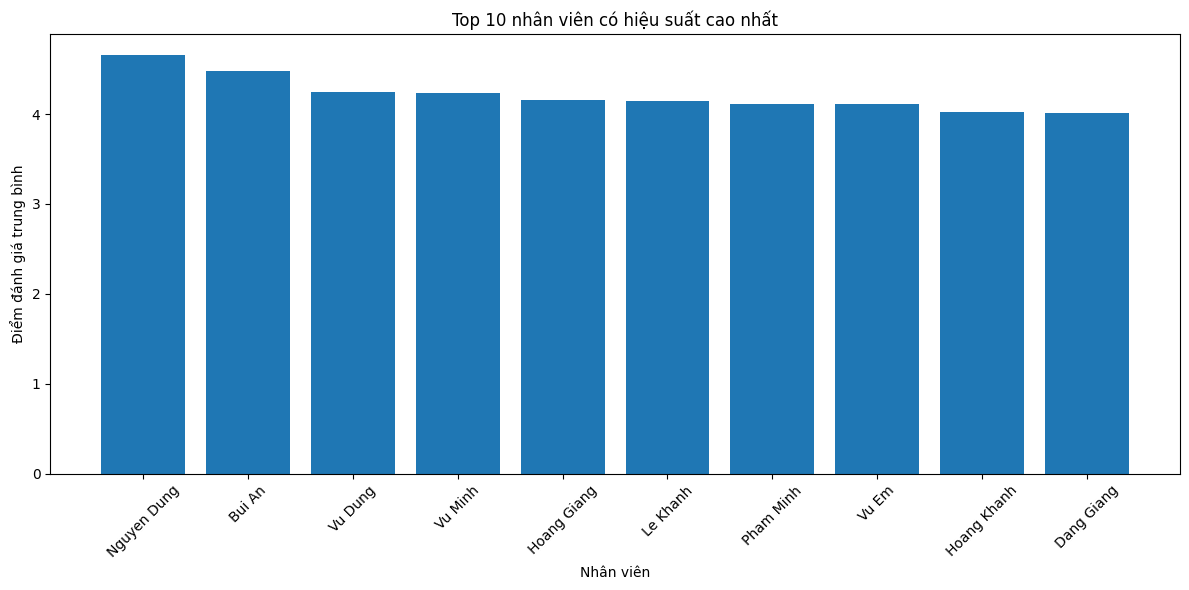


Chọn biểu đồ bạn muốn xem:
1. Phân bố nhân sự theo phòng ban
2. Độ tuổi nhân sự
3. Đánh giá hiệu suất nhân viên
4. Hiệu quả đào tạo và phát triển
5. Thâm niên nhân viên
0. Thoát


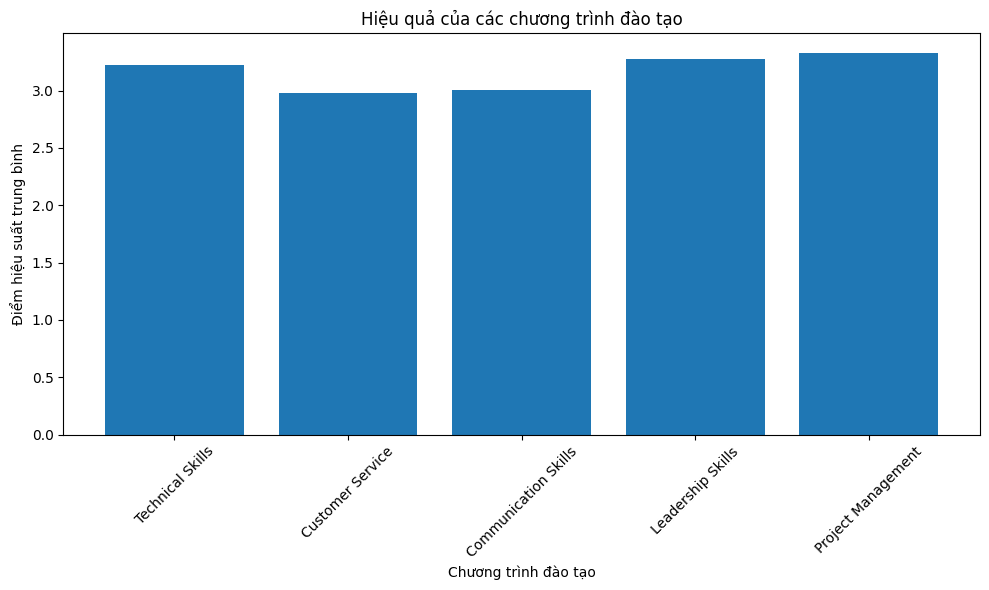


Chọn biểu đồ bạn muốn xem:
1. Phân bố nhân sự theo phòng ban
2. Độ tuổi nhân sự
3. Đánh giá hiệu suất nhân viên
4. Hiệu quả đào tạo và phát triển
5. Thâm niên nhân viên
0. Thoát


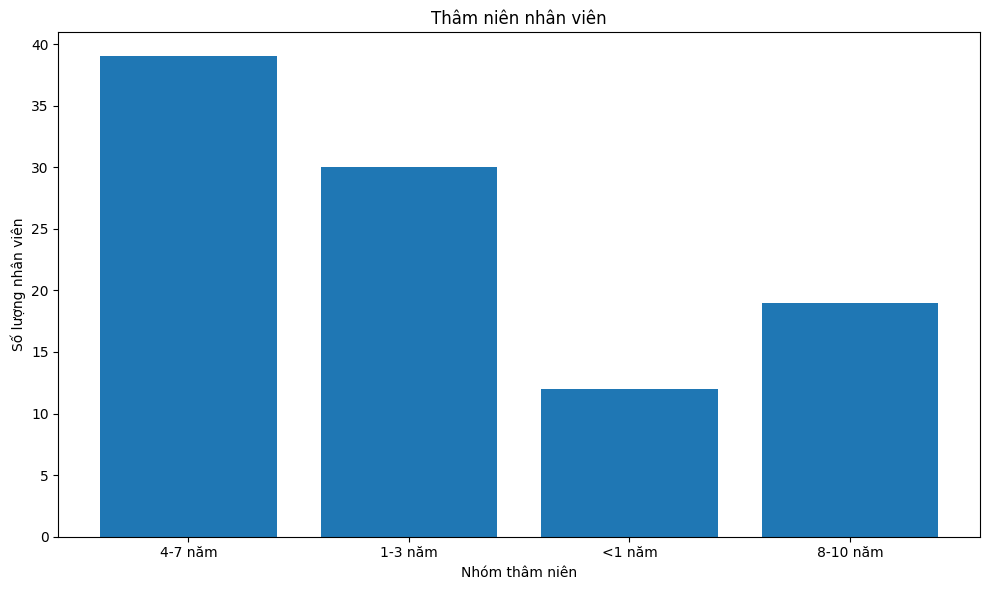


Chọn biểu đồ bạn muốn xem:
1. Phân bố nhân sự theo phòng ban
2. Độ tuổi nhân sự
3. Đánh giá hiệu suất nhân viên
4. Hiệu quả đào tạo và phát triển
5. Thâm niên nhân viên
0. Thoát


In [9]:
# Hàm main để chạy chương trình
def main():
    db = connect_to_database()
    
    while True:
        print("\nChọn biểu đồ bạn muốn xem:")
        print("1. Phân bố nhân sự theo phòng ban")
        print("2. Độ tuổi nhân sự")
        print("3. Đánh giá hiệu suất nhân viên")
        print("4. Hiệu quả đào tạo và phát triển")
        print("5. Thâm niên nhân viên")
        print("0. Thoát")
        
        choice = input("Nhập lựa chọn của bạn: ")
        
        if choice == '1':
            plot_employee_distribution(db)
        elif choice == '2':
            plot_age_distribution(db)
        elif choice == '3':
            plot_performance_evaluation(db)
        elif choice == '4':
            plot_training_effectiveness(db)
        elif choice == '5':
            plot_employee_tenure(db)
        elif choice == '0':
            break
        else:
            print("Lựa chọn không hợp lệ. Vui lòng thử lại.")

if __name__ == "__main__":
    main()